In [1]:
import sys
print("python version: ", sys.version)

import pandas as pd
print("pandas version: ", pd.__version__)

import numpy as np
print('numpy version: ', np.__version__)

import scipy as sp
print('scipy version: ', sp.__version__)

import sklearn as skl
print('sklearn version: ', skl.__version__)

import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import keras as ks
print('keras version: ', ks.__version__)
print('keras backend: ', ks.backend.backend())

import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import warnings
warnings.filterwarnings('ignore')

from keras import backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_recall_curve

import random

python version:  3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
pandas version:  0.24.2
numpy version:  1.16.4
scipy version:  1.3.0
sklearn version:  0.21.2


Using TensorFlow backend.


keras version:  2.2.4
keras backend:  tensorflow
tensorflow version:  1.14.0


In [2]:
excel_file = r'geriomop-data-from-egems-paper-UPDATED-COL-FIX-ATC_2-and-behavior-change-022819.tsv'
df = pd.DataFrame(pd.read_csv(excel_file, sep='\t'))
print(df.shape)

(7584, 208)


In [3]:
# Drop features
f_drop = ["Blank-1", "ws-sudden-stop", "ws-sudden-stop-drugs", "ws-prolonged-psychotropics", "mds-toilet-prgm-atmptd"] + \
         ['Deleted-%d' % i for i in range(1, 13)] + ['Psychotropic-%d' % i for i in range(1, 6)] + \
         ['Psychotropic-%d-average-daily-dose' % i for i in range(1, 6)] + ["Entry-discharge-type"]

f_drop += ["acute_mental_change", "aphasia", "balance_toileting", "balance_turning_around", "bipolar", "bph", \
           "cam_motor_retardation", "cerebralpalsy", "cirrhosis", "cms-long-stay", "comatose", "conduct_pain_assmnt",\
           "dysrhythmias", "embolisms", "facility", "hemiplegia/hemiparesis", "hepatitis", "huntingtons", "hyperkalemia",\
           "hypertension", "hyperthyroidism", "hyponatremia", "hypotension", "hypothyroidism", \
           "limb_prosthesis_past_7_days", "marital-status", "mds-conduct-staff-assessment-mental-status", \
           "mds-dehydrated", "mds-delirium-scale", "mds-excess-weight-loss", "mds-long-term-memory-ok", \
           "mds-pressure-ulcer-stage-1", "mds-pressure-ulcer-stage-2", "mds-pressure-ulcer-stage-3", \
           "mds-pressure-ulcer-stage-4", "mds-short-term-memory-ok", "mds-staff-assess-pain", "multiple-sclerosis", \
           "neurogenic-bladder", "obstructive-uropathy", "paraplegia", "pneumonia", "ptsd", "pvd", "quadriplegia", \
           "renal-failure", "schizophrenia", "septicemia", "stroke", "tourettes", "traumatic-brain-injury", \
           "tuberculosis", "wound", "ws-antibiotic-anticoag-coexposure", "ws-diuretic-adl", \
           "ws-meclizine-psych-coexposure", "ws-meclizine-psych-coexposure", "ws-meclizine-psych-coexposure",\
           "ws-meclizine-psych-coexposure", "ws-meclizine-psych-coexposure", \
           "ws-psychotropic-with-not-ordered-weight-loss", "ws-tramadol-antidepressant-coexposure"]
 
# Missing value means not relevant
f_one_hot = ["Mds-fall-2-6-months-to-admission", "Mds-fall-last-month-to-admission", "mds-pain-last-five-days", \
             "recent-start-other-fall-risk-rx"]
cate_one_hot = [['Yes', 'No', 'Unable to answer']] * 3 + [['Yes', 'No']]

f_period = [("Psychotropic-%d-Start-date" % i, 'Psychotropic-%d-End-date' % i, 'Psychotropic-%d-Period' % i) for i in range(1, 6)]

f_label = ['mds-cognitive-scale', 'mds-pain-freq-last-five-days', 'mds-pain-intensity']
dic_label = [{'Independent': 0, 'Modified Independence': 1, 'Moderately Impaired': 2, 'Severely Impaired': 3}, \
             {'Continuous': 4, 'Frequent': 3, 'Occasional': 2, 'Rare': 1, 'Unable to respond': 0}, \
             {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Very severe, horrible': 4}]

f_transform = [('mds-cognitive-scale', 3, 0), ('mds-pain-freq-last-five-days', 4, 0), ('mds-pain-intensity', 4, 0)] + \
              [('Psychotropic-%d-Period' % i, 0, 0) for i in range(1, 6)]

In [4]:
# Encode features (originally) with no missing values
f_drop += ["predictor-date", "projected-date", "PPS-assessment", "Federal-assessment"]

f_period += [('episode-start-date', 'episode-end-date', 'episode-period'),\
             ('stay-start-date', 'stay-end-date', 'stay-period')]

f_label += ["mds-stay-trans-short-to-long", "mds-antianxiety-medication", \
            "mds-antidepressant-medication", "mds-antipsychotic-medication", "mds-antibiotic-medication",
            "mds-anticoagulant-medication", "mds-diuretic-medication", \
            "mds-hypnotic-medication", "mds-behavioral-symptoms", "mds-behavioral-symptoms-to-others", \
            "mds-depression", "mds-fever", "mds-impaired-mobility", "mds-impaired-transfer", \
            "mds-internal-bleeding", "mds-malnutrition", "mds-no-problem-conditions", "mds-vomiting", \
            "mds-impaired-walk-in-room", "mds-impaired-walk-in-corridor", "mds-impaired-locomot-unit", \
            "mds-impaired-locomot-other"] + ["mds-pain-non-verbal"]
dic_label += [{'Yes': 1, 'No': 0}] * 22 + [{'None/Mild':0,'Moderate/Severe':1}]

f_one_hot += ["race", "gender", "mds-bims-summary-ranking"]
cate_one_hot += [['White', 'Black', 'Other'], \
                 ['Female', 'Male'], ['Intact or Moderately Intact', 'Moderate Impairment']]

In [5]:
# Features need imputation
f_one_hot += ["uti", "mdro", "anemia", "constipation", "alzheimers", "anxiety", "depression", "non-alz-dimentia", \
              "parkinsons", "psychosis", "seizure", "emphysema", "arthritis", "ashd", "cancer", "diabetes", "gerd",\
              "heart-failure", "osteoporosis", "thyroid-disorder", "transient-ischemic-attack", "mds-pain-medication", \
              "mds-received-pain-tx-non-pharm", "mds-received-prn-pain-medication", "mds-pressure-ulcer-prsnt", \
              "conduct_bims", "cane_or_crutch_past_7_days", "walker_past_7_days", "wheelchair_past_7_days", \
              "no_listed_mobility_device", "hyperlipidemia"] + \
              ["balance_while_standing", "balance_while_walking", "balance_bed_to_chair"] + ["mds-entered-from"]
cate_one_hot += [['Yes', 'No']] * 31 + \
                [["Steady at all times", "able to stabilize without assistance", \
                  "able to stabilize with assistance", "Activity did not occur"]] * 3 + \
                [["Acute Hospital", "Psychiatric Hospital", "Another nursing home or swing bed", "Hospice", \
                  "Inpatient rehabilitation facility",
                  "Community (private home/apt., board/care, assisted living, group home)", "Other"]]

f_label += ["mds-urinary-incontinence", "functlimit_rom_upper", "functlimit_rom_lower", "does_resident_wander"] + \
           ["cam_inattention", "cam_disorganized_thought", "cam_altered_conc"]
dic_label += [{"Always continent": 0, "Occasionally incontinent": 1, "Frequently incontinent": 2,\
               "Always incontinent": 3, "Catheter - not rated": np.nan}] + \
             [{"No impairment": 0, "Impairment on one side": 1, "Impairment on both sides": 2}] * 2 + \
             [{"Behavior not exhibited": 0, "1 to 3 days": 1, "4 to 6 days": 2, "occurred daily": 3}] + \
             [{"Behavior not present": 0, "Behavior present, fluctuates": 1, "Behavior continuously present": 2}] * 3

f_transform += [("mds-urinary-incontinence", 3, 0), ("cam_inattention", 2, 0), ("cam_disorganized_thought", 2, 0), \
                ("cam_altered_conc", 2, 0), ("functlimit_rom_upper", 2, 0), \
                ("functlimit_rom_lower", 2, 0), ("does_resident_wander", 3, 0)]

In [6]:
# Set sdd=0 to NA
for i in range(1, 6):
    df.loc[df['psych_sdd_%d' % i] == 0, 'psych_sdd_%d' % i] = np.nan
# These data were dropped in Experiment 1
f_transform += [('psych_sdd_%d' % i, 0, 0) for i in range(1, 6)]

In [7]:
# Dropping min effective dose and one hot encoding ATC psychotropic drugs
# These data were not used in Experiment 1 b/c of missing values
f_drop += ["min_effective_dose_%d" % i for i in range(1, 6)]

atc_list = []
for i in range(1, 6):
    atc_list.append(df.groupby('atc_%d' % i)['min_effective_dose_%d' % i].first())
atc_codes = pd.concat(atc_list)
atc_codes = atc_codes[~atc_codes.index.duplicated()].index.tolist()
f_one_hot += ["atc_%d" % i for i in range(1, 6)]
cate_one_hot += [atc_codes] * 5

In [8]:
# generate target
target = df['outcome-Mds-fall-since-prior-assessment'].map({'None': 0, 'Yes': 1})
dff = df.drop(['outcome-mds-fall-no-injury', 'outcome-mds-fall-minor-injury', 'outcome-mds-fall-major-injury', \
               'outcome-Mds-fall-since-prior-assessment', 'outcome-riskmaster-fall-incident'], axis=1)

In [10]:
# train test split
from sklearn.model_selection import GroupShuffleSplit
def train_test_split(df, target, groupby, radio, random_state):
    train_idx, test_idx = next(GroupShuffleSplit(train_size=radio, test_size=1-radio, random_state=random_state).split(df, target, df[groupby]))
    return df.iloc[train_idx], df.iloc[test_idx], target.iloc[train_idx], target.iloc[test_idx]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(dff, target, 'patient-id', 0.7, 0)
print('Total number of patients: %d' % len(df.groupby('patient-id')))
print('Number of patients in training set: %d' % len(X_train.groupby('patient-id')))

Total number of patients: 3133
Number of patients in training set: 2193


In [12]:
# drop feature
def drop_features(df, f):
    df.drop(f, axis=1, inplace=True)
    
# one hot encoding
def one_hot_encoding(df, features, categories):
    for f, c in zip(features, categories):
        df[f] = df[f].astype('category', categories=c)
    return pd.get_dummies(df, columns=features, prefix=features)

# compute date difference
def date_diff(start, end):
    return (pd.to_datetime(end) - pd.to_datetime(start)) / np.timedelta64(1, 'D')

# generate date diff features
def generate_period(df, f):
    for start, end, period in f:
        df[period] = date_diff(df[start], df[end])
        df.drop([start, end], axis=1, inplace=True)
        
# label encoding
def label_encoding(df, features, dictionaries):
    for f, dic in zip(features, dictionaries):
        df[f] = df[f].map(dic)
        
# sin&cos transform
def col_transform(df, col, mmax, mmin, df_ref=None):
    if(mmax <= mmin):
        # for test set, if max&min not set, use training set value
        if(df_ref is not None): 
            mmax = df_ref[col].max()
            mmin = df_ref[col].max()
        else:
            mmax = df[col].max()
            mmin = df[col].min()
    angle = 0.25 * np.pi * (df[col] - mmin) / (mmax - mmin) + 0.125 * np.pi
    return (np.cos(angle), np.sin(angle))

def df_transform(df, f, df_ref=None):
    for col, mmax, mmin in f:
        df[col + '_x'], df[col + '_y'] = col_transform(df, col, mmax, mmin, df_ref)
        df[col + '_x'].fillna(0, inplace=True)
        df[col + '_y'].fillna(0, inplace=True)
        df.drop(col, axis=1, inplace=True)

In [13]:
%%time
## Training set data reshaping
generate_period(X_train, f_period)
label_encoding(X_train, f_label, dic_label)
X_train_original = X_train.copy() # store value range
df_transform(X_train, f_transform)
X_train = one_hot_encoding(X_train, f_one_hot, cate_one_hot)
drop_features(X_train, f_drop)

CPU times: user 1min 18s, sys: 1.17 s, total: 1min 19s
Wall time: 21.6 s


In [14]:
X_train_use = X_train.copy()

In [15]:
print(X_train.dtypes[X_train.dtypes == 'object'].index)

Index([], dtype='object')


In [16]:
# missing data describe
def missing_summary(df):
    missing_cnt = df.isna().sum()
    missing_data = pd.concat([missing_cnt, missing_cnt/df.shape[0]], axis=1, keys=['count', 'percentage'])
    return missing_data[missing_data['percentage'] != 0].sort_values(by='percentage', ascending=False)

missing_summary(X_train_use)

,count,percentage


In [17]:
%%time
## Test set data reshaping
generate_period(X_test, f_period)
label_encoding(X_test, f_label, dic_label)
df_transform(X_test, f_transform, X_train_original)
X_test = one_hot_encoding(X_test, f_one_hot, cate_one_hot)
drop_features(X_test, f_drop)

CPU times: user 19.3 s, sys: 43.5 ms, total: 19.3 s
Wall time: 19.3 s


In [18]:
X_test_use = X_test.copy()

In [19]:
print(X_test.dtypes[X_test.dtypes == 'object'].index)

Index([], dtype='object')


In [20]:
missing_summary(X_test_use)

,count,percentage


In [21]:
X_train_use.shape

(5301, 398)

In [22]:
X_test_use.shape

(2283, 398)

In [23]:
X_train_use.head()

,patient-id,current-stay-days,cumulative-days-in-facility,mds-stay-trans-short-to-long,age,mds-antianxiety-medication,mds-antidepressant-medication,mds-antipsychotic-medication,mds-antibiotic-medication,mds-anticoagulant-medication,...,atc_5_N06AB10,atc_5_N06AX05,atc_5_N06AX11,atc_5_N06AX12,atc_5_N06AX16,atc_5_N06AX21,atc_5_N06AX24,atc_5_N05AA01,atc_5_N05BA05,atc_5_N06AX23
0,10353,7,7,0,67,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10364,7,7,1,84,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,10386,7,7,1,77,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5000,7,7,0,90,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,5003,7,7,1,90,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
X_test_use.head()

,patient-id,current-stay-days,cumulative-days-in-facility,mds-stay-trans-short-to-long,age,mds-antianxiety-medication,mds-antidepressant-medication,mds-antipsychotic-medication,mds-antibiotic-medication,mds-anticoagulant-medication,...,atc_5_N06AB10,atc_5_N06AX05,atc_5_N06AX11,atc_5_N06AX12,atc_5_N06AX16,atc_5_N06AX21,atc_5_N06AX24,atc_5_N05AA01,atc_5_N05BA05,atc_5_N06AX23
2,10379,7,7,0,84,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,10385,7,7,1,85,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
14,5032,7,7,0,85,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
15,5032,8,8,0,86,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16,5032,7,7,0,86,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# The main difference in this experiment from experiment 2 is that it  
# includes clincally important variables (based on domain knowledge), 
# imputing them if neede, and drops a bunch of likely non-relevant features 
# (TODO:recall if this is based on feature selection + expert knowledge?)
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Masking, TimeDistributed
from numpy.random import seed
from tensorflow import set_random_seed
from copy import deepcopy
from keras.preprocessing.sequence import pad_sequences

In [26]:
def scaler_transform(X_train_use, X_test_use):    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train_use.drop('patient-id', axis=1))
    X_train_transformed = pd.DataFrame(scaler.transform(X_train_use.drop('patient-id', axis=1)), \
                                       columns=X_train_use.columns[1:], index=X_train_use.index)                                   
    X_train_transformed['patient-id'] = X_train_use['patient-id']
    X_test_transformed = pd.DataFrame(scaler.transform(X_test_use.drop('patient-id', axis=1)), \
                                       columns=X_test_use.columns[1:], index=X_test_use.index) 
    X_test_transformed['patient-id'] = X_test_use['patient-id']
    return X_train_transformed, X_test_transformed

In [27]:
def add_previous_outcome(X, Y):
    X = X.copy()
    x1, x2 = [], []
    pids = X['patient-id'].unique()
    for pid in pids:
        df = Y[X[X['patient-id']==pid].index]
        if(df.shape[0] == 1):
            x1.append(pd.Series([0]))
            x2.append(pd.Series([0]))
        else:
            # input 1=(1, 0), 0=(0, 1), NA=(0, 0)
            x1.append(pd.Series([0]))
            x1.append(df[:-1])
            x2.append(pd.Series([0]))
            x2.append(df[:-1].map({0: 1, 1: 0}))
    X['input_outcome_x'] = pd.Series(pd.concat(x1, ignore_index=True).tolist(), index=X.index)
    X['input_outcome_y'] = pd.Series(pd.concat(x2, ignore_index=True).tolist(), index=X.index)
    return X

In [28]:
## This step converts the outcome to a point in x,y coordinates where fall (1) = (1,0); no fall (0) = (0,1); and NA = (0,0) 
X_train_use = add_previous_outcome(X_train_use, y_train)
X_test_use = add_previous_outcome(X_test_use, y_test)

## This step transforms the data to range between 0 and 1
X_train_transformed, X_test_transformed = scaler_transform(X_train_use, X_test_use)

In [29]:
def generate_nested_list(X, Y):
    x_list, y_list = [], [] 
    pids = X['patient-id'].unique()
    for pid in pids:
        df = X[X['patient-id']==pid]
        y_list.append(Y[df.index].values)
        x_list.append([record for record in df.drop('patient-id', axis=1).values])
    return x_list, y_list

def mygenerator(x_list, y_list=None):
    if(y_list is not None):
        while True:
            for x, y in zip(x_list, y_list):
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])), y
    else:
        while True:
            for x in x_list:
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])) 
                
def fit_model(model, epoch, X_train, y_train, X_valid=None, y_valid=None, verbose=0):
    history = model.fit(X_train, y_train, epochs=epoch, verbose=verbose)
    if(verbose != 0):
        plot_history(history)
    return history

def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_history(history, loss=None, val_loss=None):
    if(history is not None):
        loss = history.history['loss']
    plt.figure()
    plt.plot(loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if('val_loss' in history.history):
        val_loss = history.history['val_loss']
        plt.plot(val_loss)
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [30]:
def pad_data(X, maxlen):
    return pad_sequences(X, maxlen=maxlen, dtype='float64', padding='post')

def pad_all(X_train, y_train, X_test, y_test, maxlen):
    return pad_data(X_train, maxlen), pad_data(y_train, maxlen), pad_data(X_test, maxlen), pad_data(y_test, maxlen)

In [31]:
def auroc(y_predict, y_true, plot=False):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1)    
    if(plot):
        plot_roc_curve(fpr, tpr)
    return auc(fpr, tpr)


def find_best_f1(y_predict, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1) 
    max_f1, th = 0, 0
    for threshold in thresholds:
        f1 = f1_score(y_true, y_predict > threshold)
        if(f1 > max_f1):
            max_f1 = f1
            th = threshold
    return max_f1, th

def other_metrics(y_predict, y_true, threshold):
    y_threshold = y_predict > threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_threshold).ravel()
    return precision_score(y_true, y_threshold), recall_score(y_true, y_threshold),\
            accuracy_score(y_true, y_threshold), float(tn) / (tn + fp)

In [47]:
from sklearn.model_selection import GroupKFold
def kfold_validation(unit, ratio, epoch, X, y, groupby, n_features, k=5, verbose=0, max_timestamps=20):
    auroc_list = []
    other_metric_list = []
    for train_idx, valid_idx in GroupKFold(n_splits=5).split(X, y, X[groupby]):
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
        X_train, y_train = generate_nested_list(X_train, y_train)
        X_valid, y_valid = generate_nested_list(X_valid, y_valid)
        X_train_pad, y_train_pad, X_valid_pad, y_valid_pad = pad_all(X_train, y_train, X_valid, y_valid, max_timestamps)
        y_train_pad = y_train_pad.reshape(y_train_pad.shape[0], y_train_pad.shape[1], 1)
        seed(1)
        set_random_seed(2)
        model = build_model(unit, ratio, max_timestamps, n_features)
        fit_model(model, epoch, X_train_pad, y_train_pad, verbose=verbose)
        y_valid_len = [len(y) for y in y_valid]
        y_predict = model.predict(X_valid_pad)
        y_predict = truncate_prediction(y_predict, y_valid_len)
        y_true = np.concatenate(y_valid)
        auroc_list.append(auroc(y_predict, y_true))
        f1, th = find_best_f1(y_predict, y_true)
        precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
        other_metric_list.append((precision, recall, accuracy, specificity,f1,th))
    return (auroc_list, other_metric_list)

In [33]:
# shape: (num_of_patients, num_of_records, num_of_features)
X_train_list, y_train_list = generate_nested_list(X_train_transformed, y_train)
X_test_list, y_test_list = generate_nested_list(X_test_transformed, y_test)

In [34]:
## comparing this to the experiment 1 transformed dataset to confirm that this has 
## diagnoses and ATC codes while the other does not
X_train_transformed.to_csv (r'/tmp/exp3_train_transformed_df.csv', index = False, header=True)

In [35]:
X_train_transformed.shape

(5301, 400)

In [36]:
X_test_transformed.shape

(2283, 400)

In [37]:
max_timestamps = df.groupby(['patient-id']).size().max()
print(max_timestamps)

19


In [38]:
n_features = X_train_list[0][0].shape[0]
print(n_features)

399


In [39]:
## function to build an LSTM
from keras import regularizers
from keras.optimizers import Adagrad, Adadelta
def build_model(units, dropout_ratio, n_timesteps, n_dimensions):
    model = Sequential()
    model.add(Masking(input_shape=(n_timesteps, n_dimensions)))
    model.add(LSTM(units, return_sequences=True, recurrent_dropout=dropout_ratio, dropout=0.5))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['binary_accuracy'])
    return model

In [40]:
def truncate_prediction(y_, y_len):
    y_concat = []
    for i, y in enumerate(y_):
        y_concat.append(np.concatenate(y[:y_len[i], :]))
    y_concat = np.concatenate(y_concat)
    return y_concat

In [41]:
## the data is padded so that the final shape is as follows with the outcome data array having the same
## shape but only one value
#  array([[patient 1 data record 1],  
#         [patient 1 data record 2],
#         ...
#         [patient 1 data record 19],
#        ],
#        [[patient 2 data record 1],  
#         [patient 2 data record 2],
#         ...
#         [patient 2 data record 19],
#        ],
#        ...
#       )
# 
X_train_pad, y_train_pad, X_test_pad, y_test_pad = pad_all(X_train_list, y_train_list, X_test_list, y_test_list, max_timestamps)
y_train_pad = y_train_pad.reshape((2193, 19, 1))

W0423 14:24:02.677610 139979077625664 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0423 14:24:02.679584 139979077625664 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0423 14:24:02.692014 139979077625664 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0423 14:24:02.777742 139979077625664 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_

Epoch 1/175
2193/2193 [==============================] - 4s 2ms/step - loss: 0.4624 - binary_accuracy: 0.8207
Epoch 2/175
2193/2193 [==============================] - 3s 1ms/step - loss: 0.4351 - binary_accuracy: 0.8226
Epoch 3/175
2193/2193 [==============================] - 3s 1ms/step - loss: 0.4235 - binary_accuracy: 0.8253
Epoch 4/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.4244 - binary_accuracy: 0.8234
Epoch 5/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.4202 - binary_accuracy: 0.8221
Epoch 6/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.4243 - binary_accuracy: 0.8225
Epoch 7/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.4176 - binary_accuracy: 0.8208
Epoch 8/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.4165 - binary_accuracy: 0.8267
Epoch 9/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.4141 - binary_accuracy: 0.8293
Epoch 10/1

2193/2193 [==============================] - 3s 1ms/step - loss: 0.3845 - binary_accuracy: 0.8402
Epoch 75/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.3848 - binary_accuracy: 0.8383
Epoch 76/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.3868 - binary_accuracy: 0.8304
Epoch 77/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.3826 - binary_accuracy: 0.8386
Epoch 78/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.3897 - binary_accuracy: 0.8385
Epoch 79/175
2193/2193 [==============================] - 3s 1ms/step - loss: 0.3921 - binary_accuracy: 0.8366
Epoch 80/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.3828 - binary_accuracy: 0.8381
Epoch 81/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.3821 - binary_accuracy: 0.8384
Epoch 82/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.3900 - binary_accuracy: 0.8352
Epoch 83/175
2

2193/2193 [==============================] - 2s 1ms/step - loss: 0.3692 - binary_accuracy: 0.8438
Epoch 148/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.3758 - binary_accuracy: 0.8411A: 0s - loss: 0.3735 - binary_accu
Epoch 149/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.3759 - binary_accuracy: 0.8400
Epoch 150/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.3727 - binary_accuracy: 0.8401
Epoch 151/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.3718 - binary_accuracy: 0.8462
Epoch 152/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.3679 - binary_accuracy: 0.8479
Epoch 153/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.3761 - binary_accuracy: 0.8377
Epoch 154/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.3708 - binary_accuracy: 0.8447
Epoch 155/175
2193/2193 [==============================] - 2s 1ms/step - loss: 0.372

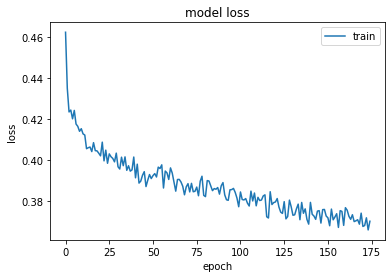

auroc:  0.7145072092878098
f1:  0.4273504273504274
threshold:  0.15814418
precision:  0.32201405152224827
recall:  0.6351039260969977
accuracy:  0.6771791502409111
specificity:  0.687027027027027
CPU times: user 26min 48s, sys: 5min 17s, total: 32min 5s
Wall time: 7min 5s


In [42]:
%%time
### A single run w/out cross-validation
# with previous outcome added to the features
# outcome is added before scaling
seed(1)
set_random_seed(2)
model = build_model(32, 0.5, max_timestamps, n_features)
fit_model(model, 175, X_train_pad, y_train_pad, verbose=1)
y_predict = model.predict(X_test_pad)
y_test_len = [len(y) for y in y_test_list]
y_predict = truncate_prediction(y_predict, y_test_len)
y_true = np.concatenate(y_test_list)
print('auroc: ', auroc(y_predict, y_true))
f1, th = find_best_f1(y_predict, y_true)
print('f1: ', f1);
print('threshold: ', th)
precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print('specificity: ', specificity)

Epoch 1/225
1755/1755 [==============================] - 3s 2ms/step - loss: 0.4644 - binary_accuracy: 0.8174
Epoch 2/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4385 - binary_accuracy: 0.8226
Epoch 3/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4248 - binary_accuracy: 0.8215
Epoch 4/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4168 - binary_accuracy: 0.8288
Epoch 5/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4200 - binary_accuracy: 0.8239
Epoch 6/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4179 - binary_accuracy: 0.8303
Epoch 7/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4145 - binary_accuracy: 0.8246
Epoch 8/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4042 - binary_accuracy: 0.8315
Epoch 9/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4127 - binary_accuracy: 0.8249
Epoch 10/2

1755/1755 [==============================] - 2s 1ms/step - loss: 0.3874 - binary_accuracy: 0.8374
Epoch 75/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3908 - binary_accuracy: 0.8354
Epoch 76/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3883 - binary_accuracy: 0.8372
Epoch 77/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3854 - binary_accuracy: 0.8384
Epoch 78/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3814 - binary_accuracy: 0.8462
Epoch 79/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3849 - binary_accuracy: 0.8397
Epoch 80/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3827 - binary_accuracy: 0.8419
Epoch 81/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3787 - binary_accuracy: 0.8430
Epoch 82/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3784 - binary_accuracy: 0.8441
Epoch 83/225
1

1755/1755 [==============================] - 2s 1ms/step - loss: 0.3700 - binary_accuracy: 0.8505
Epoch 148/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3702 - binary_accuracy: 0.8423
Epoch 149/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3720 - binary_accuracy: 0.8414
Epoch 150/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3748 - binary_accuracy: 0.8428
Epoch 151/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3688 - binary_accuracy: 0.8458
Epoch 152/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3707 - binary_accuracy: 0.8463
Epoch 153/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3715 - binary_accuracy: 0.8445
Epoch 154/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3686 - binary_accuracy: 0.8509
Epoch 155/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3663 - binary_accuracy: 0.8448
Epoch 

1755/1755 [==============================] - 2s 1ms/step - loss: 0.3606 - binary_accuracy: 0.8463
Epoch 221/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3560 - binary_accuracy: 0.8534
Epoch 222/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3599 - binary_accuracy: 0.8478
Epoch 223/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3561 - binary_accuracy: 0.8518
Epoch 224/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3602 - binary_accuracy: 0.8473
Epoch 225/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3634 - binary_accuracy: 0.8485


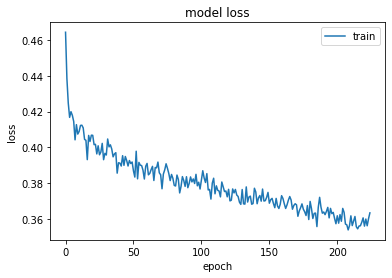

Epoch 1/225
1755/1755 [==============================] - 4s 2ms/step - loss: 0.4653 - binary_accuracy: 0.8226
Epoch 2/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4331 - binary_accuracy: 0.8227
Epoch 3/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4263 - binary_accuracy: 0.8251
Epoch 4/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4217 - binary_accuracy: 0.8279
Epoch 5/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4201 - binary_accuracy: 0.8275
Epoch 6/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4161 - binary_accuracy: 0.8265
Epoch 7/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4135 - binary_accuracy: 0.8311
Epoch 8/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4140 - binary_accuracy: 0.8308
Epoch 9/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.4145 - binary_accuracy: 0.8274
Epoch 10/2

1755/1755 [==============================] - 2s 1ms/step - loss: 0.3841 - binary_accuracy: 0.8322
Epoch 75/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3831 - binary_accuracy: 0.8341
Epoch 76/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3759 - binary_accuracy: 0.8430
Epoch 77/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3882 - binary_accuracy: 0.8385
Epoch 78/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3789 - binary_accuracy: 0.8407
Epoch 79/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3777 - binary_accuracy: 0.8405
Epoch 80/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3845 - binary_accuracy: 0.8397
Epoch 81/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3791 - binary_accuracy: 0.8420
Epoch 82/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3806 - binary_accuracy: 0.8418
Epoch 83/225
1

1755/1755 [==============================] - 2s 1ms/step - loss: 0.3667 - binary_accuracy: 0.8446
Epoch 148/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3658 - binary_accuracy: 0.8477
Epoch 149/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3672 - binary_accuracy: 0.8462
Epoch 150/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3714 - binary_accuracy: 0.8400
Epoch 151/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3670 - binary_accuracy: 0.8484
Epoch 152/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3645 - binary_accuracy: 0.8458
Epoch 153/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3686 - binary_accuracy: 0.8429
Epoch 154/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3656 - binary_accuracy: 0.8500
Epoch 155/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3671 - binary_accuracy: 0.8458
Epoch 

1755/1755 [==============================] - 2s 1ms/step - loss: 0.3547 - binary_accuracy: 0.8502
Epoch 221/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3591 - binary_accuracy: 0.8512
Epoch 222/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3472 - binary_accuracy: 0.8558
Epoch 223/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3544 - binary_accuracy: 0.8522
Epoch 224/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3505 - binary_accuracy: 0.8534
Epoch 225/225
1755/1755 [==============================] - 2s 1ms/step - loss: 0.3543 - binary_accuracy: 0.8498


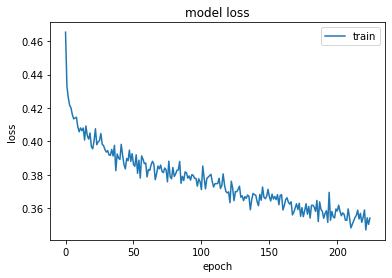

Epoch 1/225
1754/1754 [==============================] - 4s 2ms/step - loss: 0.4654 - binary_accuracy: 0.8240
Epoch 2/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4339 - binary_accuracy: 0.8218
Epoch 3/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4217 - binary_accuracy: 0.8226
Epoch 4/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4149 - binary_accuracy: 0.8285
Epoch 5/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4181 - binary_accuracy: 0.8249
Epoch 6/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4176 - binary_accuracy: 0.8217
Epoch 7/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4131 - binary_accuracy: 0.8254
Epoch 8/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4107 - binary_accuracy: 0.8287
Epoch 9/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4093 - binary_accuracy: 0.8317
Epoch 10/2

1754/1754 [==============================] - 2s 1ms/step - loss: 0.3784 - binary_accuracy: 0.8425
Epoch 75/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3770 - binary_accuracy: 0.8471
Epoch 76/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3756 - binary_accuracy: 0.8412
Epoch 77/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3789 - binary_accuracy: 0.8389
Epoch 78/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3813 - binary_accuracy: 0.8389
Epoch 79/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3786 - binary_accuracy: 0.8394
Epoch 80/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3813 - binary_accuracy: 0.8341
Epoch 81/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3778 - binary_accuracy: 0.8375
Epoch 82/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3805 - binary_accuracy: 0.8386
Epoch 83/225
1

1754/1754 [==============================] - 2s 1ms/step - loss: 0.3599 - binary_accuracy: 0.8513
Epoch 148/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3645 - binary_accuracy: 0.8452
Epoch 149/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3690 - binary_accuracy: 0.8429
Epoch 150/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3624 - binary_accuracy: 0.8485
Epoch 151/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3663 - binary_accuracy: 0.8450
Epoch 152/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3628 - binary_accuracy: 0.8462
Epoch 153/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3697 - binary_accuracy: 0.8448
Epoch 154/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3593 - binary_accuracy: 0.8489
Epoch 155/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3664 - binary_accuracy: 0.8449
Epoch 

1754/1754 [==============================] - 2s 1ms/step - loss: 0.3532 - binary_accuracy: 0.8540
Epoch 221/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3528 - binary_accuracy: 0.8526
Epoch 222/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3551 - binary_accuracy: 0.8492
Epoch 223/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3561 - binary_accuracy: 0.8486
Epoch 224/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3501 - binary_accuracy: 0.8568
Epoch 225/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3512 - binary_accuracy: 0.8539


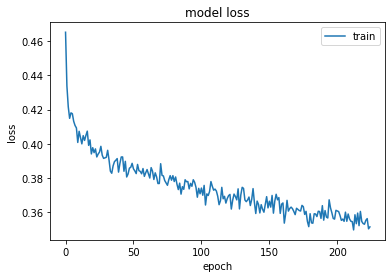

Epoch 1/225
1754/1754 [==============================] - 4s 2ms/step - loss: 0.4738 - binary_accuracy: 0.8146
Epoch 2/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4398 - binary_accuracy: 0.8196
Epoch 3/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4322 - binary_accuracy: 0.8207
Epoch 4/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4314 - binary_accuracy: 0.8201
Epoch 5/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4260 - binary_accuracy: 0.8237
Epoch 6/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4220 - binary_accuracy: 0.8256
Epoch 7/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4183 - binary_accuracy: 0.8238
Epoch 8/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4140 - binary_accuracy: 0.8238
Epoch 9/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4154 - binary_accuracy: 0.8297
Epoch 10/2

1754/1754 [==============================] - 2s 1ms/step - loss: 0.3819 - binary_accuracy: 0.8392
Epoch 75/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3827 - binary_accuracy: 0.8387
Epoch 76/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3903 - binary_accuracy: 0.8302
Epoch 77/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3885 - binary_accuracy: 0.8361
Epoch 78/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3895 - binary_accuracy: 0.8359
Epoch 79/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3897 - binary_accuracy: 0.8357
Epoch 80/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3850 - binary_accuracy: 0.8389
Epoch 81/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3892 - binary_accuracy: 0.8331
Epoch 82/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3844 - binary_accuracy: 0.8366
Epoch 83/225
1

1754/1754 [==============================] - 2s 1ms/step - loss: 0.3757 - binary_accuracy: 0.8393
Epoch 148/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3668 - binary_accuracy: 0.8447
Epoch 149/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3665 - binary_accuracy: 0.8448
Epoch 150/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3691 - binary_accuracy: 0.8447
Epoch 151/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3691 - binary_accuracy: 0.8487
Epoch 152/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3701 - binary_accuracy: 0.8423
Epoch 153/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3678 - binary_accuracy: 0.8424
Epoch 154/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3762 - binary_accuracy: 0.8366
Epoch 155/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3696 - binary_accuracy: 0.8421
Epoch 

1754/1754 [==============================] - 2s 1ms/step - loss: 0.3564 - binary_accuracy: 0.8515
Epoch 221/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3522 - binary_accuracy: 0.8511
Epoch 222/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3671 - binary_accuracy: 0.8462
Epoch 223/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3549 - binary_accuracy: 0.8486
Epoch 224/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3581 - binary_accuracy: 0.8490
Epoch 225/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3602 - binary_accuracy: 0.8501


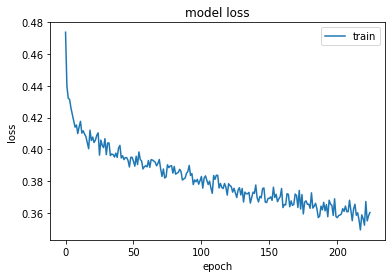

Epoch 1/225
1754/1754 [==============================] - 4s 2ms/step - loss: 0.4737 - binary_accuracy: 0.8170
Epoch 2/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4412 - binary_accuracy: 0.8188
Epoch 3/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4326 - binary_accuracy: 0.8149
Epoch 4/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4236 - binary_accuracy: 0.8200
Epoch 5/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4248 - binary_accuracy: 0.8195
Epoch 6/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4199 - binary_accuracy: 0.8221
Epoch 7/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4176 - binary_accuracy: 0.8182
Epoch 8/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4191 - binary_accuracy: 0.8233
Epoch 9/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.4101 - binary_accuracy: 0.8285
Epoch 10/2

1754/1754 [==============================] - 2s 1ms/step - loss: 0.3852 - binary_accuracy: 0.8381
Epoch 75/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3831 - binary_accuracy: 0.8381
Epoch 76/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3860 - binary_accuracy: 0.8343
Epoch 77/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3813 - binary_accuracy: 0.8380
Epoch 78/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3875 - binary_accuracy: 0.8338
Epoch 79/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3835 - binary_accuracy: 0.8392
Epoch 80/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3867 - binary_accuracy: 0.8341
Epoch 81/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3830 - binary_accuracy: 0.8348
Epoch 82/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3799 - binary_accuracy: 0.8383
Epoch 83/225
1

1754/1754 [==============================] - 2s 1ms/step - loss: 0.3651 - binary_accuracy: 0.8430
Epoch 148/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3736 - binary_accuracy: 0.8444
Epoch 149/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3651 - binary_accuracy: 0.8476
Epoch 150/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3715 - binary_accuracy: 0.8397
Epoch 151/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3671 - binary_accuracy: 0.8409
Epoch 152/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3692 - binary_accuracy: 0.8411
Epoch 153/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3658 - binary_accuracy: 0.8413
Epoch 154/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3745 - binary_accuracy: 0.8387
Epoch 155/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3653 - binary_accuracy: 0.8464
Epoch 

1754/1754 [==============================] - 2s 1ms/step - loss: 0.3545 - binary_accuracy: 0.8517
Epoch 221/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3545 - binary_accuracy: 0.8464
Epoch 222/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3561 - binary_accuracy: 0.8474
Epoch 223/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3587 - binary_accuracy: 0.8514
Epoch 224/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3578 - binary_accuracy: 0.8464
Epoch 225/225
1754/1754 [==============================] - 2s 1ms/step - loss: 0.3528 - binary_accuracy: 0.8506


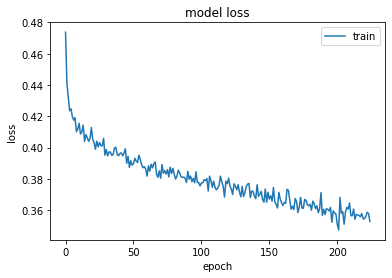

In [48]:
## Run 5-fold cross-validation to get average performance characteristics
unit = 32
ratio = 0.5
epoch = 225
(auroc_list, other_metric_list) = kfold_validation(unit, ratio, epoch, X_train_transformed, y_train, 'patient-id', \
                                                   n_features=n_features, verbose=1)

In [49]:
## other_metric_list has precision, recall, accuracy, specificity, f1, threshold for metrics
ave_prec = np.mean([x[0] for x in other_metric_list])
print("average precision:" + str(ave_prec))

ave_recall = np.mean([x[1] for x in other_metric_list])
print("average recall:" + str(ave_recall))

ave_specificity = np.mean([x[3] for x in other_metric_list])
print("average specificity:" + str(ave_specificity))

ave_f1 = np.mean([x[4] for x in other_metric_list])
print("average F1:" + str(ave_f1))

average precision:0.37647159234290467
average recall:0.5452527096836868
average specificity:0.7929412911921775
average F1:0.4375439239745429


In [50]:
max_f1 = np.max([x[4] for x in other_metric_list])
print("max F1: " + str(max_f1))

max F1: 0.45045045045045046


In [51]:
## Average metrics performance
print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))

unit: 32	epoch: 225	auroc_mean: 0.714686	auroc_std: 0.016830
